# Swithching Power

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from halfBridgeModule import detectCommutation, switchingLosesHalfBridge

In [35]:
labels = {'i_out_a': 'Ia',
          'sw_a': 'Three Phase Inverter1.IGBT Leg1.PWM_Modulator_TOP_1',
          'i_out_b': 'Ib',
          'sw_b': 'Three Phase Inverter1.IGBT Leg2.PWM_Modulator_TOP_1',
          'i_out_c': 'Ic',
          'sw_c': 'Three Phase Inverter1.IGBT Leg3.PWM_Modulator_TOP_1'}

folder_captures = '../Typhoon files/'
captures_names = ['half_bridge_3_Carrier.csv',
                  'half_bridge_3_Geometrica.csv',
                  'half_bridge_3_SVM.csv']

df_carrier_based = pd.read_csv(folder_captures+captures_names[0])
df_geometric = pd.read_csv(folder_captures+captures_names[1])
df_svm = pd.read_csv(folder_captures+captures_names[2])

captures_df = {'Carrier': df_carrier_based,
               'Geometric': df_geometric,
               'SVM': df_svm}

In [36]:
# df_carrier_based

## Importando os modelos

In [37]:
import pickle

folder_models = '../models/'
models_name = ['FDB045AN08A0.pklmod', 'IRF1407.pklmod', 'IRFH5207.pklmod',
                'PSMN5R560YS.pklmod', 'Si4980DY.pklmod', 'SUP90N08-8m2P.pklmod']
models = {}

for model_name in models_name:
    with open(folder_models+model_name, 'rb') as fpkl:
        tmp_load = pickle.load(fpkl)
    models[model_name] = tmp_load

In [38]:
models

{'FDB045AN08A0.pklmod': {'eon': poly1d([-1.97160324e-10,  2.32164421e-08, -1.83410387e-07,  5.99040577e-06]),
  'eoff': poly1d([-1.14463638e-11,  4.36901325e-09,  4.03114665e-07, -1.12415235e-06]),
  'erec': poly1d([1.38074627e-11, 2.83250298e-09, 3.16198745e-07, 1.91134959e-06]),
  'eDon': poly1d([ 3.08523643e-13,  3.37091603e-09,  3.78194474e-07, -1.28032393e-06]),
  'name': 'FDB045AN08A0',
  'type': 'MOSFET'},
 'IRF1407.pklmod': {'eon': poly1d([-2.99558456e-10,  3.58642033e-08,  9.70452977e-07,  4.68341188e-04]),
  'eoff': poly1d([-1.27532941e-10,  2.43248689e-08, -1.45104229e-06,  4.51495684e-04]),
  'erec': poly1d([-4.41736903e-11,  8.86714630e-09,  1.76473778e-06,  4.56529902e-04]),
  'eDon': poly1d([ 8.69007885e-11,  2.95371267e-09, -1.50096082e-06,  4.29073420e-04]),
  'name': 'IRF1407',
  'type': 'MOSFET'},
 'IRFH5207.pklmod': {'eon': poly1d([-2.60744078e-11,  5.92852577e-09,  3.08700200e-07,  8.41110246e-07]),
  'eoff': poly1d([-8.30192763e-12,  3.40956907e-09,  2.65413278e-0

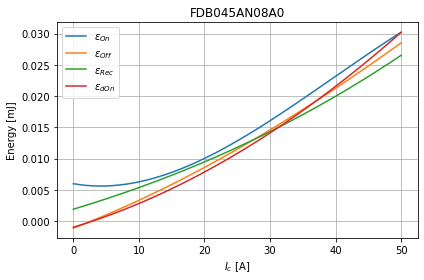

In [45]:
# plt.figure(figsize=(15, 3))

for j, model in enumerate(models.values()):
    name = model['name']
    type_ = model['type']
    
    p_eon = model['eon']
    p_eoff = model['eoff']
    p_erec = model['erec']
    
    i = np.linspace(0, 50, 200)

    eon  = p_eon(i)
    eoff = p_eoff(i)
    erec = p_erec(i)
    eDon = p_eDon(i)

    
#     plt.subplot(161+j)
    plt.plot(i, eon*1e3, label='$\epsilon_{On}$')
    plt.plot(i, eoff*1e3, label='$\epsilon_{Off}$')
    plt.plot(i, erec*1e3, label='$\epsilon_{Rec}$')
    plt.plot(i, eDon*1e3, label='$\epsilon_{dOn}$')
#     plt.plot(i, eDon*1e3, label='Poly D On')
    plt.title(f'{name}') 
    plt.xlabel('$I_c$ [A]') 
    plt.ylabel('Energy [mJ]')
    plt.grid()
    plt.legend()
    break
plt.tight_layout()
plt.show()

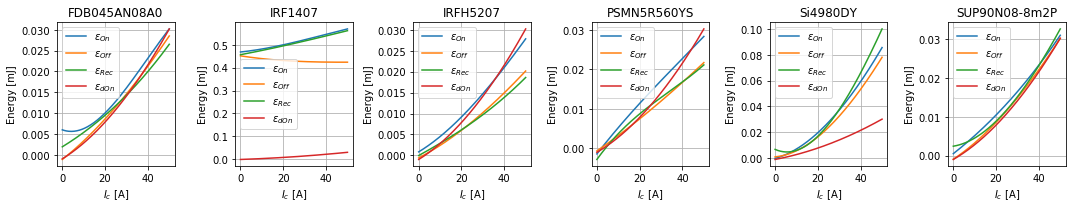

In [43]:
plt.figure(figsize=(15, 3))

for j, model in enumerate(models.values()):
    name = model['name']
    type_ = model['type']
    
    p_eon = model['eon']
    p_eoff = model['eoff']
    p_erec = model['erec']
    
    i = np.linspace(0, 50, 200)

    eon  = p_eon(i)
    eoff = p_eoff(i)
    erec = p_erec(i)
    eDon = p_eDon(i)

    
    plt.subplot(161+j)
    plt.plot(i, eon*1e3, label='$\epsilon_{On}$')
    plt.plot(i, eoff*1e3, label='$\epsilon_{Off}$')
    plt.plot(i, erec*1e3, label='$\epsilon_{Rec}$')
    plt.plot(i, eDon*1e3, label='$\epsilon_{dOn}$')
    plt.title(f'{name}') 
    plt.xlabel('$I_c$ [A]') 
    plt.ylabel('Energy [mJ]')
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

In [47]:
switching_results_order = []
switching_results = []

for df_modulation_key, df_modulation in captures_df.items():
    time = df_modulation.index
    
    # Separação dos canais de cada uma das fases do inversor trifásico
    
    Iout_a = df_modulation[labels['i_out_a']]; print(Iout_a.min(), Iout_a.max())
    pwm_s1_a = df_modulation[labels['sw_a']]
    
    Iout_b = df_modulation[labels['i_out_b']]; print(Iout_b.min(), Iout_b.max())
    pwm_s1_b = df_modulation[labels['sw_b']]
    
    Iout_c = df_modulation[labels['i_out_c']]; print(Iout_c.min(), Iout_c.max())
    pwm_s1_c = df_modulation[labels['sw_c']]
    
    for model_k in models:
        model = models[model_k]
        
        p_eon = model['eon']
        p_eoff = model['eoff']
        p_erec = model['erec']
        p_eDon = model['eDon']
        
        
        P_sw_a = switchingLosesHalfBridge(pwm_s1_a, Iout_a, time[-1] - time[0], p_eon, p_eoff, p_erec, p_eDon, verbate=False)
        P_sw_b = switchingLosesHalfBridge(pwm_s1_b, Iout_b, time[-1] - time[0], p_eon, p_eoff, p_erec, p_eDon, verbate=False)
        P_sw_c = switchingLosesHalfBridge(pwm_s1_c, Iout_c, time[-1] - time[0], p_eon, p_eoff, p_erec, p_eDon, verbate=False)
        
        P_sw_tot = {'S1': P_sw_a['S1'] + P_sw_b['S1'] + P_sw_c['S1'],
                    'S2': P_sw_a['S2'] + P_sw_b['S2'] + P_sw_c['S2'],
                    'D1': P_sw_a['D1'] + P_sw_b['D1'] + P_sw_c['D1'],
                    'D2': P_sw_a['D2'] + P_sw_b['D2'] + P_sw_c['D2']}
        
        switching_results.append(P_sw_tot)
        switching_results_order.append((df_modulation_key, model_k.replace('.pklmod', '')))

-11.762909 11.770828999999999
-11.766409 11.765684
-11.766814 11.765216
-11.856117999999999 11.516229
-11.852339 11.516074
-11.849811 11.519888
-18.521696 20.586832
-18.5208 20.571968
-18.511253 20.577806


In [48]:
switching_results_order

[('Carrier', 'FDB045AN08A0'),
 ('Carrier', 'IRF1407'),
 ('Carrier', 'IRFH5207'),
 ('Carrier', 'PSMN5R560YS'),
 ('Carrier', 'Si4980DY'),
 ('Carrier', 'SUP90N08-8m2P'),
 ('Geometric', 'FDB045AN08A0'),
 ('Geometric', 'IRF1407'),
 ('Geometric', 'IRFH5207'),
 ('Geometric', 'PSMN5R560YS'),
 ('Geometric', 'Si4980DY'),
 ('Geometric', 'SUP90N08-8m2P'),
 ('SVM', 'FDB045AN08A0'),
 ('SVM', 'IRF1407'),
 ('SVM', 'IRFH5207'),
 ('SVM', 'PSMN5R560YS'),
 ('SVM', 'Si4980DY'),
 ('SVM', 'SUP90N08-8m2P')]

## Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

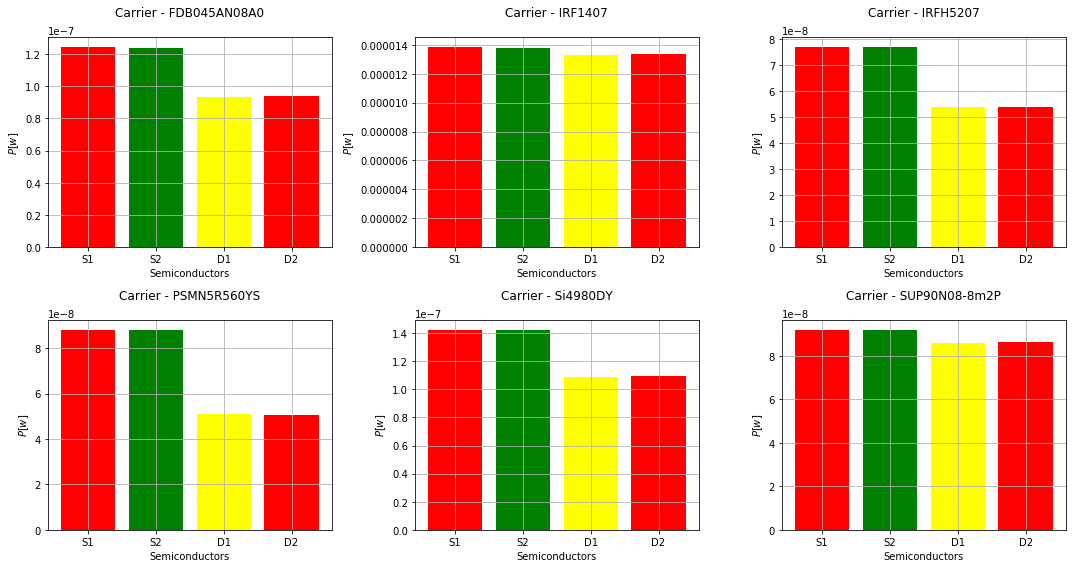

In [70]:
plt.figure(figsize=(15, 8))
for j, (name, P_sw) in enumerate(zip(switching_results_order[:6], switching_results[:6])):
    plt.subplot(2, 3, j+1)
    x = np.arange(4)
    plt.bar(x, P_sw.values(), color =['red', 'green', 'yellow'])
    plt.xticks(x, P_sw.keys())
    plt.ylabel('$P [w]$')
    plt.xlabel('Semiconductors')
    plt.grid()
    plt.title('%s - %s\n' % (name))
plt.tight_layout()
plt.show()

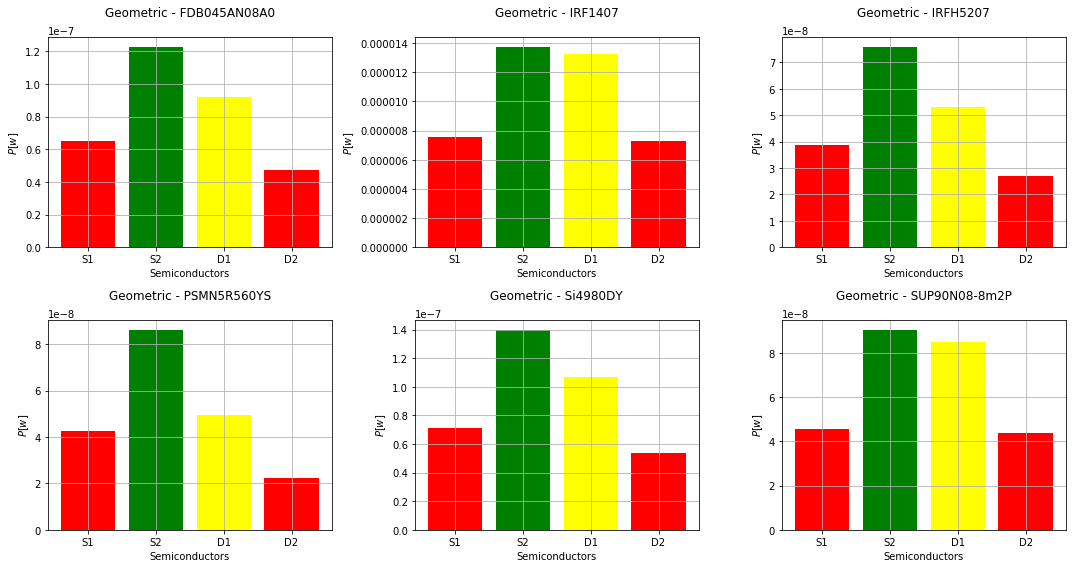

In [72]:
plt.figure(figsize=(15, 8))
for j, (name, P_sw) in enumerate(zip(switching_results_order[6:12], switching_results[6:12])):
    plt.subplot(2, 3, j+1)
    x = np.arange(4)
    plt.bar(x, P_sw.values(), color =['red', 'green', 'yellow'])
    plt.xticks(x, P_sw.keys())
    plt.ylabel('$P [w]$')
    plt.xlabel('Semiconductors')
    plt.grid()
    plt.title('%s - %s\n' % (name))
plt.tight_layout()
plt.show()

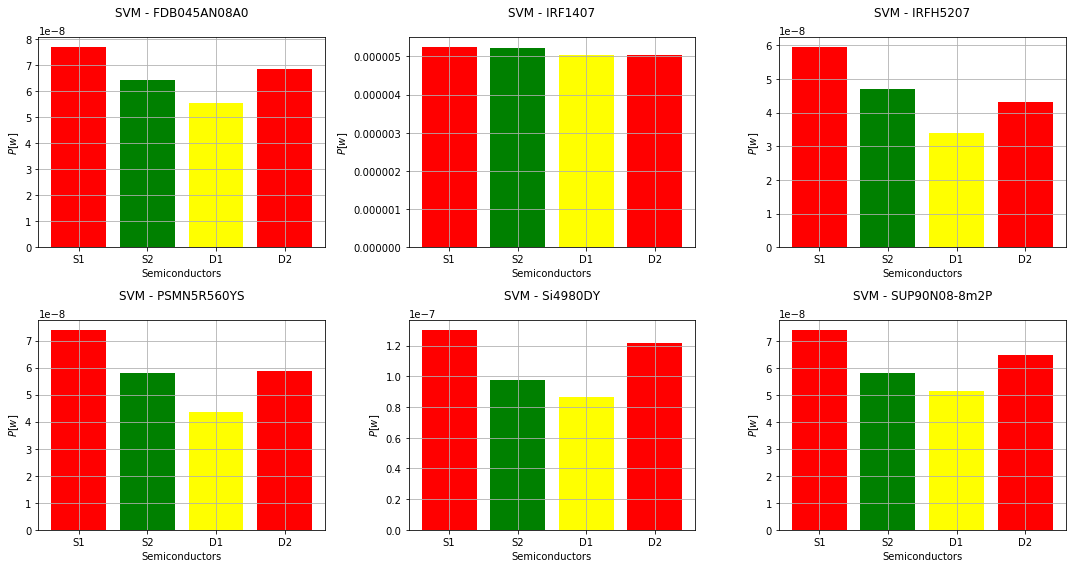

In [75]:
plt.figure(figsize=(15, 8))
for j, (name, P_sw) in enumerate(zip(switching_results_order[12:], switching_results[12:])):
    plt.subplot(2, 3, j+1)
    x = np.arange(4)
    plt.bar(x, P_sw.values(), color =['red', 'green', 'yellow'])
    plt.xticks(x, P_sw.keys())
    plt.ylabel('$P [w]$')
    plt.xlabel('Semiconductors')
    plt.grid()
    plt.title('%s - %s\n' % (name))
plt.tight_layout()
plt.show()

In [62]:
plt.figure?

In [57]:
plt.subplot?

In [30]:
# labels = ['%s - %s' % (mod, cmp) for mod, cmp in switching_results_order]
# S1 = [P_sw['S1']for P_sw in switching_results]
# S2 = [P_sw['S2']for P_sw in switching_results]
# D1 = [P_sw['D1']for P_sw in switching_results]
# D2 = [P_sw['D2']for P_sw in switching_results]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots(figsize=(12, 5))
# rects1 = ax.bar(x - width/2, S1, width, label='S1')
# rects2 = ax.bar(x - width/4, S2, width, label='S2')
# rects3 = ax.bar(x + width/4, D1, width, label='D1')
# rects4 = ax.bar(x + width/2, D2, width, label='D2')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Switching Loss [mJ]')
# # ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# # autolabel(rects1)
# # autolabel(rects2)
# # autolabel(rects3)
# # autolabel(rects4)

# fig.tight_layout()
# plt.grid()
# plt.show()